## **🌳 PROJECT 2: Street Tree Health vs. Air Quality**


# Do Healthier Street Trees Correlate With Better Air Quality in NYC? 

In this project, I combine two NYC datasets [the Street Tree Census and Air Quality (PM2.5)] to explore whether neighborhoods with healthier trees also have cleaner air.

Link 1: https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh
Link 2: https://data.cityofnewyork.us/Environment/Air-Quality/c3uy-2p5r/about_data

I’ll walk through every step: loading the data, cleaning it, merging it, and creating one visualization that reflects data from both datasets.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
trees = pd.read_csv("/Users/apple/Desktop/CiC/[gulay].github.io/Project2/2015_Street_Tree_Census_-_Tree_Data_20251120.csv")
air = pd.read_csv("/Users/apple/Desktop/CiC/[gulay].github.io/Project2/Air_Quality_20251120.csv")

# Quick sanity check
print(trees.columns)
print(air.columns)

Index(['tree_id', 'block_id', 'created_at', 'tree_dbh', 'stump_diam',
       'curb_loc', 'status', 'health', 'spc_latin', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other', 'address', 'postcode',
       'zip_city', 'community board', 'borocode', 'borough', 'cncldist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp', 'council district',
       'census tract', 'bin', 'bbl'],
      dtype='object')
Index(['Unique ID', 'Indicator ID', 'Name', 'Measure', 'Measure Info',
       'Geo Type Name', 'Geo Join ID', 'Geo Place Name', 'Time Period',
       'Start_Date', 'Data Value', 'Message'],
      dtype='object')


# **🌳 Explaining the Street Tree Census Dataset**

# What is the Street Tree Census?

The NYC Street Tree Census is a massive, citywide inventory of every street tree in New York City. It’s conducted roughly once a decade by NYC Parks together with thousands of trained volunteers. The dataset I’m using (the 2015 Street Tree Census) includes detailed information for over 680,000 trees, such as:

* Species
* Diameter
* Location (borough, neighborhood, latitude/longitude)
* Status (Alive, Dead, Stump)
- Health condition (Good, Fair, Poor)

The purpose of the census is to help the city understand urban forestry conditions, plan maintenance, prioritize planting, and improve tree health across NYC. The data is considered one of the most comprehensive public urban tree inventories in the United States.

# 🌱 What Does Tree “Health” Mean?

Each tree is labeled as:
* Good – full canopy, no major stress
* Fair – visible stress or minor damage
* Poor – significant decline, sparse canopy, likely to be removed

It’s a quick way to summarize the tree’s physical condition based on visual inspection.

# 🌫️ What Is PM2.5 and Why Does It Matter?

PM2.5 refers to tiny airborne particles less than 2.5 micrometers wide. They come from traffic, heating systems, and industry.
They matter because:
* They are harmful to human health
* They can stress or damage vegetation
* Trees help reduce PM2.5 by trapping particles

This makes PM2.5 a meaningful pollutant to compare with tree health across NYC boroughs.

# **🔍 Initial Data Exploration**

In [3]:
trees.head()
air.head()

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message
0,878218,386,Ozone (O3),Mean,ppb,UHF42,402,West Queens,Summer 2023,06/01/2023,34.365989,NaN
1,876975,375,Nitrogen dioxide (NO2),Mean,ppb,UHF42,501,Port Richmond,Summer 2023,06/01/2023,11.331992,NaN
2,876900,375,Nitrogen dioxide (NO2),Mean,ppb,UHF42,207,East Flatbush - Flatbush,Summer 2023,06/01/2023,12.020333,NaN
3,877140,375,Nitrogen dioxide (NO2),Mean,ppb,CD,205,Fordham and University Heights (CD5),Summer 2023,06/01/2023,14.123178,NaN
4,874556,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF34,410,Rockaways,Summer 2023,06/01/2023,8.150637,NaN


# Which Columns Matter?

For the Street Tree Census, the columns I will use are:

* borough – tells us which NYC borough the tree is in
* health – tree condition category (“Good”, “Fair”, “Poor”)
* status – allows me to keep only trees that are alive

For the Air Quality dataset, the key columns are:

* Geo Place Name – borough name
* Name – pollutant type
* Time Period – year or time frame for the measurement
* Data Value – the PM2.5 pollution value

These are the columns directly needed to compare tree health with PM2.5 levels.

# Which Columns I Will Drop

In both datasets, there are many columns that aren’t relevant for this project, such as:
- Tree attributes like species, diameter, steward information, and address details
- Air quality metadata such as measure IDs, units, dataset release notes, and geographic codes

These columns don’t affect the borough-level relationship I’m analyzing, so they are dropped to simplify the dataset.

# Caveats and Considerations

- The Street Tree Census was collected once in 2015, so it provides a snapshot in time.
- The Air Quality dataset includes measurements for different time frames, so I filtered to “Annual Average 2015” to match the Tree Census year.
- Air quality is measured by borough averages, which are coarse compared to the fine-grained tree-level data.
- Tree health is based on visual inspection, which has some subjectivity.
- These differences don’t prevent the analysis, but they are important context when interpreting the results.

# **Cleaning and Preparing the Tree Dataset**

Goal: For each borough, we calculate what percentage of alive trees are in “Good” health.
We’ll keep only alive trees (status == "Alive"), drop missing health or borough, group by borough and health and compute the percent of trees in “Good” health.

In [4]:
# only rows where tree is alive and both health and borough are present
trees_clean = trees.loc[
    (trees["status"] == "Alive") &
    trees["health"].notna() &
    trees["borough"].notna(),
    ["borough", "health"]
]

# counting trees by borough and health category
tree_health_counts = (
    trees_clean
    .groupby(["borough", "health"])
    .size()
    .reset_index(name="tree_count")
)

# total alive trees per borough
total_per_boro = (
    tree_health_counts
    .groupby("borough")["tree_count"]
    .sum()
    .reset_index(name="total_trees")
)

# number of "Good" trees per borough
good_trees = (
    tree_health_counts
    .loc[tree_health_counts["health"] == "Good", ["borough", "tree_count"]]
    .rename(columns={"tree_count": "good_trees"})
)

# combining totals + good-trees counts
tree_health_boro = (
    total_per_boro
    .merge(good_trees, on="borough", how="left")
    .fillna({"good_trees": 0})
)

# percent of alive trees that are in good health
tree_health_boro["pct_good_trees"] = (
    100 * tree_health_boro["good_trees"] / tree_health_boro["total_trees"]
)

tree_health_boro


,borough,total_trees,good_trees,pct_good_trees
0,Bronx,80585,66603,82.649376
1,Brooklyn,169744,138212,81.423791
2,Manhattan,62427,47358,75.861406
3,Queens,237974,194008,81.524872
4,Staten Island,101442,82669,81.493859


**Interpretation of the Borough-level Tree Health Summary** : In the table above, I calculated the percentage of alive trees that are rated “Good” in each borough. To do this, I first counted all alive trees per borough, then counted how many of those were labeled “Good,” and finally computed the share as a percentage.

This percentage is a simple but useful proxy for overall vegetation health. While tree health can vary by species, age, and local conditions, the share of trees in “Good” condition gives a broad indication of how well street trees are doing in each borough. It allows me to compare boroughs on a consistent scale and later relate these differences to the borough-level PM2.5 air quality data.

# **Cleaning the Air Quality Data**

For the air quality data, I only need borough-level PM2.5 values for 2015 so they match the year of the Street Tree Census. To do this, I filtered the dataset to:

* Geo Type Name == "Borough"
* Name == "Fine particles (PM 2.5)"
* Time Period == "Annual Average 2015"

Then I kept just the borough name and the PM2.5 value. This gives me a clean table of one PM2.5 measurement per borough, which I can directly merge with the borough-level tree-health data.

In [7]:
# filtering to borough-level PM2.5 values for 2015
pm25_boro_2015 = (
    air
    .loc[
        (air["Geo Type Name"] == "Borough") &
        (air["Name"] == "Fine particles (PM 2.5)") &
        (air["Time Period"] == "Annual Average 2015"),
        ["Geo Place Name", "Time Period", "Data Value"]
    ]
    .rename(columns={
        "Geo Place Name": "borough",
        "Data Value": "pm25_ug_m3"
    })
)

pm25_boro_2015


,borough,Time Period,pm25_ug_m3
9230,Bronx,Annual Average 2015,9.24
9234,Brooklyn,Annual Average 2015,8.74
9323,Queens,Annual Average 2015,8.35
9330,Manhattan,Annual Average 2015,10.19
9827,Staten Island,Annual Average 2015,7.69


# Interpreting the Air Quality Data

The PM2.5 values shown above are averaged measurements, which makes sense because air quality fluctuates throughout the year. Using the annual average gives a stable, comparable value for each borough.

I used borough-level aggregation because it matches the granularity of the tree dataset, where tree health was also summarized at the borough level. Keeping both datasets at the same level makes the merge straightforward and avoids mixing incompatible geographic units.

Finally, all filtering and aggregation was done with groupby rather than hard-coding borough names. This ensures the code will still work if new boroughs appear in the dataset or if row order changes.

## **🖼️ Visualizing Tree Health and Air Quality**

# Step 1: Merging the Tree Health and Air Quality Data

At this stage, I have two borough-level tables:

**tree_health_boro**: Contains one row per borough with the total number of alive trees, the number of trees in “Good” condition, and the percentage of trees that are healthy.

**pm25_boro_2015**: Contains one row per borough with the annual average PM2.5 value for 2015.

Both datasets include a borough column, which gives me a common key to join them. By merging these two tables on borough, I create one combined dataset (merged) that includes both tree health metrics and the air quality measure for each borough. This merged table is what I’ll use for the visualizations that follow.

In [10]:
# Merge tree health and air quality on borough
merged = tree_health_boro.merge(pm25_boro_2015, on="borough", how="inner")

# Sort for nicer plotting
merged = merged.sort_values("borough")

merged

,borough,total_trees,good_trees,pct_good_trees,Time Period,pm25_ug_m3
0,Bronx,80585,66603,82.649376,Annual Average 2015,9.24
1,Brooklyn,169744,138212,81.423791,Annual Average 2015,8.74
2,Manhattan,62427,47358,75.861406,Annual Average 2015,10.19
3,Queens,237974,194008,81.524872,Annual Average 2015,8.35
4,Staten Island,101442,82669,81.493859,Annual Average 2015,7.69


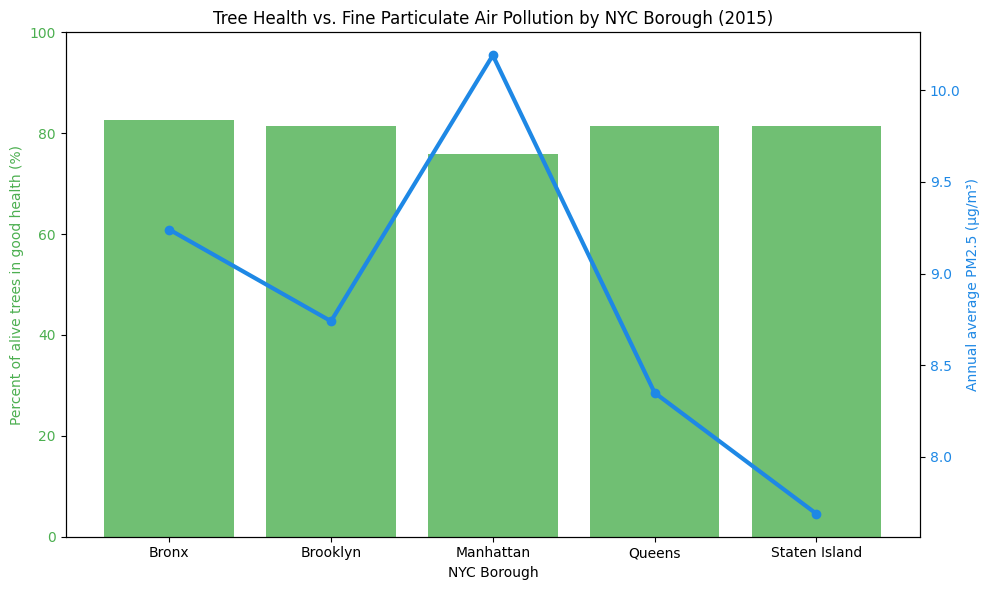

In [11]:
# Improved combined visualization with color
fig, ax1 = plt.subplots(figsize=(10, 6))

# Colors
bar_color = "#4CAF50"    # green
line_color = "#1E88E5"   # blue

# Bars: percent of trees in good health
ax1.bar(
    merged["borough"],
    merged["pct_good_trees"],
    color=bar_color,
    alpha=0.8,
    label="Percent of trees in 'Good' health"
)
ax1.set_xlabel("NYC Borough")
ax1.set_ylabel("Percent of alive trees in good health (%)", color=bar_color)
ax1.tick_params(axis='y', labelcolor=bar_color)
ax1.set_ylim(0, 100)

# Second y-axis for PM2.5
ax2 = ax1.twinx()
ax2.plot(
    merged["borough"],
    merged["pm25_ug_m3"],
    color=line_color,
    marker="o",
    linewidth=3,
    label="PM2.5 (µg/m³)"
)
ax2.set_ylabel("Annual average PM2.5 (µg/m³)", color=line_color)
ax2.tick_params(axis='y', labelcolor=line_color)

plt.title("Tree Health vs. Fine Particulate Air Pollution by NYC Borough (2015)")
plt.tight_layout()
plt.show()


# **Interpreting the First Visualization**

This chart compares two measures for each NYC borough:
* The green bars show the percentage of alive trees that are in “Good” health.
* The blue line shows the annual average PM2.5 level (fine particulate air pollution) in 2015.

A few patterns stand out:
1. Tree health is fairly high across all boroughs, generally between 75%–83% of alive trees rated “Good.” Queens and Brooklyn have slightly higher shares, while Manhattan shows the lowest.

2. PM2.5 levels vary more noticeably than the tree-health percentages.
* Manhattan has the highest PM2.5, which aligns with heavier traffic and dense development.
* Staten Island has the lowest PM2.5, reflecting lower density and fewer pollution sources.

3.  There is a loose inverse pattern: boroughs with cleaner air (lower PM2.5) tend to have slightly healthier trees, while boroughs with worse air (higher PM2.5) tend to have worse tree-health percentages.
* This is not a strong or perfect relationship, but it is visible: for example, Manhattan has both the highest pollution and the lowest tree-health rate.

Overall, the visualization suggests that air quality may be one factor among many influencing urban tree health, but tree health remains relatively consistent across boroughs. The chart shows correlation, not causation, but it provides a useful starting point for exploring how environmental conditions relate to urban vegetation health.

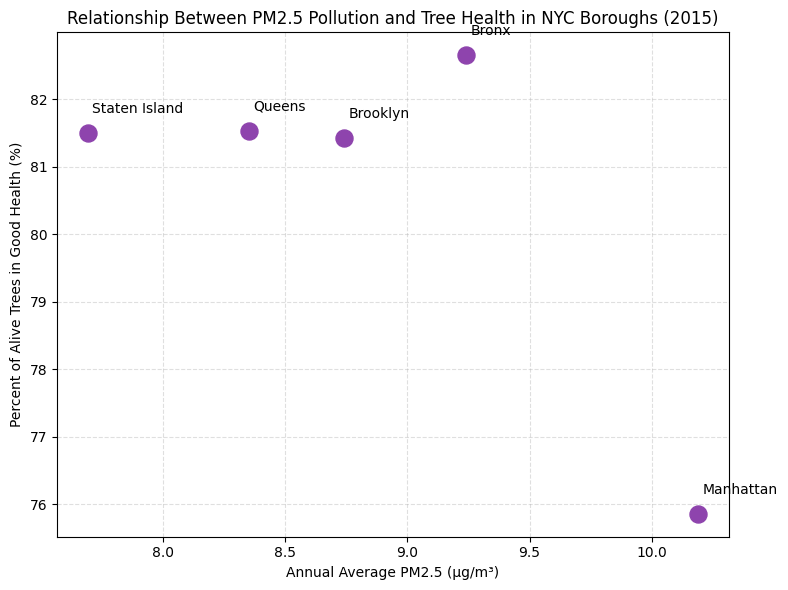

In [18]:
plt.figure(figsize=(8,6))

plt.scatter(
    merged["pm25_ug_m3"],
    merged["pct_good_trees"],
    s=150,
    color="#8E44AD"
)

# Label each point with borough name
for i, row in merged.iterrows():
    plt.text(
        row["pm25_ug_m3"] + 0.02,
        row["pct_good_trees"] + 0.3,
        row["borough"],
        fontsize=10
    )

plt.title("Relationship Between PM2.5 Pollution and Tree Health in NYC Boroughs (2015)")
plt.xlabel("Annual Average PM2.5 (µg/m³)")
plt.ylabel("Percent of Alive Trees in Good Health (%)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


# **Interpreting the Scatter Plot**

This scatter plot compares each borough’s annual PM2.5 level (x-axis) with the percentage of alive trees in “Good” health (y-axis). Each point represents one borough, labeled for clarity.

A few patterns stand out:
1. Manhattan is an outlier
* It has the highest PM2.5 pollution (~10.1 µg/m³).
* It also has the lowest percentage of trees in good health (~75.8%).
* This pulls the trend slightly downward on the right side of the chart.

2. Other boroughs cluster around cleaner air and better tree health
* Staten Island, Queens, Brooklyn, and the Bronx all fall between 8–9.5 µg/m³ PM2.5.
* Their tree-health percentages remain fairly high, around 81–82%.

3. The overall pattern suggests a mild negative relationship
* As PM2.5 increases, tree health appears to slightly decrease.
* The trend isn’t strong (since most boroughs cluster tightly), but Manhattan illustrates how high pollution may correlate with poorer tree condition.

Overall, this scatter plot supports the idea that better air quality may align with healthier street trees, though the relationship is not perfectly linear. Other factors—tree species, maintenance levels, and neighborhood characteristics—likely play a role as well

# **Key Takeaways**

This project compared borough-level tree health from the 2015 NYC Street Tree Census with borough-level PM2.5 air pollution for the same year. After cleaning and aggregating both datasets, two visualizations helped reveal how the two measures relate across NYC.

1. Tree health is consistently high across all boroughs.
Each borough has a large majority of its alive street trees rated “Good,” ranging from about 76% to 83%. Even though Manhattan is slightly lower, overall tree health remains strong citywide.

2. Air quality varies more widely than tree health.
Annual PM2.5 levels ranged from about 7.7 µg/m³ (Staten Island) to 10.1 µg/m³ (Manhattan). These differences align with what we expect based on traffic density and urban activity.

3. The data suggests a mild inverse relationship between pollution and tree health.
Boroughs with cleaner air tend to have slightly healthier trees, while those with higher PM2.5—especially Manhattan—show lower percentages of trees in “Good” condition. The scatter plot shows this pattern clearly, even though it’s not a tight or perfectly linear trend.

4. The relationship is correlational, not causal.
Tree health depends on many other factors: species mix, maintenance, soil conditions, neighborhood development, and microclimates. Likewise, PM2.5 comes from citywide pollution sources and isn’t driven by trees alone.